In [1]:
import datetime
import numpy as np
import pandas as pd
import pickle
import os

from datetime import timedelta

from paths_full import *

from features.holidays_feature.holidays_feature import add_ukrainian_holidays
from features.holidays_feature.holidays_feature import add_russian_holidays
from features.eclipses_feature.eclipses_feature import add_lunar_eclipses
from features.eclipses_feature.eclipses_feature import add_solar_eclipses

import duckdb

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

C:\Users\lap2r\Desktop\SD_SaaS_Project\venv\..\features/holidays_feature/csv
C:\Users\lap2r\Desktop\SD_SaaS_Project\venv\..\features/holidays_feature/csv
C:\Users\lap2r\Desktop\SD_SaaS_Project\venv\..\features/holidays_feature/csv
C:\Users\lap2r\Desktop\SD_SaaS_Project\venv\..\features/holidays_feature/csv


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
REPORTS_DATA_FILE = "./results/tfidf.csv"

OUTPUT_FOLDER = "results"
ISW_OUTPUT_DATA_FILE = "all_isw.csv"
WEATHER_EVENTS_OUTPUT_DATA_FILE = "all_hourly_weather_events.csv"

MODEL_FOLDER = "model"

tfidf_transformer_model = "tfidf_transformer"
count_vectorizer_model = "count_vectorizer"

tfidf_transformer_version = "v1"
count_vectorizer_version = "v1"

In [4]:
def isNaN(num):
    return num != num

## reading data

In [5]:
df_isw = pd.read_csv(f"{REPORTS_DATA_FILE}", sep=",")

In [6]:
df_isw.head(5)

,Name,Date,Keywords
0,assessment-2022-02-24,2022-02-24,"{'airport': 0.2998994784126706, 'kyiv': 0.2143..."
1,assessment-2022-02-25,2022-02-25,"{'kyiv': 0.363112374890174, 'local': 0.1907226..."
2,assessment-2022-02-26,2022-02-26,"{'kyiv': 0.4556135265972393, 'zaprozhia': 0.15..."
3,assessment-2022-02-28,2022-02-28,"{'kyiv': 0.3098584767279711, 'asset': 0.177635..."
4,assessment-2022-03-01,2022-03-01,"{'kyiv': 0.3755235521981471, 'chernihiv': 0.23..."


## preparing ISW reports

## reading models

In [7]:
# #load the content
# tfidf = pickle.load(open(f"{MODEL_FOLDER}/{tfidf_transformer_model}_{tfidf_transformer_version}.pkl", "rb"))
# cv = pickle.load(open(f"{MODEL_FOLDER}/{count_vectorizer_model}_{count_vectorizer_version}.pkl", "rb"))

In [8]:
# df_isw['keywords'] = df_isw['text_preprocessed_lemm'].apply(lambda x: tf_idf.conver_doc_to_vector(x,cv,tfidf))

In [9]:
# df_isw.head(5)

In [10]:
df_isw["date_datetime"] = pd.to_datetime(df_isw["Date"])

In [11]:
df_isw["date_tomorrow_datetime"] = df_isw["date_datetime"].apply(
    lambda x: x + datetime.timedelta(days=1)
)
df_isw["event_time"] = np.nan

In [12]:
df_isw = df_isw.rename(columns={"date_datetime": "report_date"})
df_isw.to_csv(f"{OUTPUT_FOLDER}/{ISW_OUTPUT_DATA_FILE}", sep=";", index=False)

In [13]:
# Add holidays data to df_isw
add_ukrainian_holidays(df_isw, day_datetime_column='report_date', column_name='ukrainian_holiday')
add_russian_holidays(df_isw, day_datetime_column='report_date', column_name='russian_holiday')
# df_isw.loc[df_isw['ukrainian_holiday'] == 1]

In [14]:
# df_isw.where(df_isw['ukrainian_holiday'] == 1)
# df_isw.sample(5)
# df_isw.loc[df_isw['ukrainian_holiday'] == 0].shape
# df_isw.shape
# df_isw.loc[df_isw['russian_holiday'] == 1]
# df_isw.loc[df_isw['ukrainian_holiday'] == 1]

## prepare events data

In [15]:
df_events = pd.read_csv(f"{ALARMS_DATA_FILE}", sep=";")

In [16]:
df_events_v2 = df_events.drop(["id", "region_id"], axis=1)
df_events_v2["event_time"] = np.nan

In [17]:
df_events_v2.head(5)
df_events_v2.shape

(19933, 8)

In [18]:
# df_events_v2["start_time"] = df_events_v2.apply(lambda x: x["start"] if not isNaN(x["start"]) else x["event_time"] , axis=1)
# df_events_v2["end_time"] = df_events_v2.apply(lambda x: x["end"] if not isNaN(x["end"]) else x["event_time"], axis=1)

In [19]:
df_events_v2["start_time"] = pd.to_datetime(df_events_v2["start"])
df_events_v2["end_time"] = pd.to_datetime(df_events_v2["end"])
df_events_v2["event_time"] = pd.to_datetime(df_events_v2["event_time"])

In [20]:
df_events_v2["start_hour"] = df_events_v2["start_time"].dt.floor("H")
df_events_v2["end_hour"] = df_events_v2["end_time"].dt.ceil("H")
df_events_v2["event_hour"] = df_events_v2["event_time"].dt.round("H")

In [21]:
df_events_v2["start_hour"] = df_events_v2.apply(
    lambda x: x["start_hour"] if not isNaN(x["start_hour"]) else x["event_hour"], axis=1
)
df_events_v2["end_hour"] = df_events_v2.apply(
    lambda x: x["end_hour"] if not isNaN(x["end_hour"]) else x["event_hour"], axis=1
)

In [22]:
df_events_v2["day_date"] = df_events_v2["start_time"].dt.date

df_events_v2.head(10)

df_events_v2["start_hour_datetimeEpoch"] = df_events_v2["start_hour"].apply(
    lambda x: int(x.timestamp()) if not isNaN(x) else None
)
df_events_v2["end_hour_datetimeEpoch"] = df_events_v2["end_hour"].apply(
    lambda x: int(x.timestamp()) if not isNaN(x) else None
)

# df_events_v2.head(10)

In [23]:
# df_events_v2[~(df_events_v2["type"]=="alarm")].shape

In [24]:
# df_events_v2[~(df_events_v2["type"]=="alarm")].head(5)

In [25]:
# df_events_v2[df_events_v2["type"]=="alarm"].shape

## prepare weather

In [26]:
df_weather = pd.read_csv(f"{WEATHER_DATA_FILE}")
df_weather["day_datetime"] = pd.to_datetime(df_weather["day_datetime"])

In [27]:
df_weather.shape

(182712, 67)

In [28]:
df_weather.head(15)

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_feelslikemax,day_feelslikemin,day_feelslike,day_dew,day_humidity,day_precip,day_precipprob,day_precipcover,day_snow,day_snowdepth,day_windgust,day_windspeed,day_winddir,day_pressure,day_cloudcover,day_visibility,day_solarradiation,day_solarenergy,day_uvindex,day_severerisk,day_sunrise,day_sunriseEpoch,day_sunset,day_sunsetEpoch,day_moonphase,day_conditions,day_description,day_icon,day_source,day_preciptype,day_stations,hour_datetime,hour_datetimeEpoch,hour_temp,hour_feelslike,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,hour_icon,hour_source,hour_stations
0,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,00:00:00,1645653600,2.4,-1.6,89.18,0.8,0.000,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,snow,obs,remote
1,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,01:00:00,1645657200,2.4,-1.5,87.90,0.6,0.000,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,fog,obs,remote
2,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,02:00:00,1645660800,2.9,-0.8,88.58,1.2,0.000,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,cloudy,obs,33177099999
3,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,03:00:00,1645664400,2.3,-1.3,86.63,0.3,0.000,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,fog,obs,remote
4,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,04:00:00,1645668000,1.9,-1.8,87.85,0.1,0.000,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,cloudy,obs,remote
5,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,2.6,4.0,-3.1,-0.2,0.0,83.7,0.118,100.0,4.17,0.1,0.1,32.4,15.5,252.7,1022.3,72.3,12.2,36.9,2.8,1.0,10.0,07:13:36,1645679616,17:51:06,1645717866,0.77,"Snow, Partially cloudy",Partly cloudy throughout the day with morning ...,snow,obs,snow,33177099999;UKLR;remote;33301099999,05:00:00,1645671600,1.9,-1.3,91.66

In [29]:
# len(clmns)

In [30]:
# exclude
weather_exclude = [
    "day_feelslikemax",
    "day_feelslikemin",
    "day_sunriseEpoch",
    "day_sunsetEpoch",
    "day_description",
    "city_latitude",
    "city_longitude",
    "city_address",
    "city_timezone",
    "city_tzoffset",
    "day_feelslike",
    "day_precipprob",
    "day_snow",
    "day_snowdepth",
    "day_windgust",
    "day_windspeed",
    "day_winddir",
    "day_pressure",
    "day_cloudcover",
    "day_visibility",
    "day_severerisk",
    "day_conditions",
    "day_icon",
    "day_source",
    "day_preciptype",
    "day_stations",
    "hour_icon",
    "hour_source",
    "hour_stations",
    "hour_feelslike",
]

In [31]:
# new_list = [x for x in clmns if (x not in weather_exclude)]
# new_list

In [32]:
df_weather_v2 = df_weather.drop(weather_exclude, axis=1)

In [33]:
df_weather_v2["city"] = df_weather_v2["city_resolvedAddress"].apply(
    lambda x: x.split(",")[0]
)
df_weather_v2["city"] = df_weather_v2["city"].replace(
    "Хмельницька область", "Хмельницький"
)

In [34]:
df_weather_v2.head(5)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,00:00:00,1645653600,2.4,89.18,0.8,0.0,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,Луцьк
1,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,01:00:00,1645657200,2.4,87.90,0.6,0.0,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,Луцьк
2,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,02:00:00,1645660800,2.9,88.58,1.2,0.0,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,Луцьк
3,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,03:00:00,1645664400,2.3,86.63,0.3,0.0,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,Луцьк
4,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,04:00:00,1645668000,1.9,87.85,0.1,0.0,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,Луцьк


In [35]:
df_weather_v2.shape

(182712, 38)

## merging data

In [36]:
REGIONS_DATA_FOLDER = "../external_data/additions"
REGIONS_DATA_FILE = "regions.csv"
df_regions = pd.read_csv(f"{REGIONS_DATA_FOLDER}/{REGIONS_DATA_FILE}")

In [37]:
df_regions.head(5)

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5


In [38]:
df_weather_reg = pd.merge(
    df_weather_v2, df_regions, left_on="city", right_on="center_city_ua"
)

In [39]:
df_weather_reg.head(10)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,00:00:00,1645653600,2.4,89.18,0.8,0.000,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
1,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,01:00:00,1645657200,2.4,87.90,0.6,0.000,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
2,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,02:00:00,1645660800,2.9,88.58,1.2,0.000,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
3,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,03:00:00,1645664400,2.3,86.63,0.3,0.000,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
4,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,04:00:00,1645668000,1.9,87.85,0.1,0.000,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
5,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,05:00:00,1645671600,1.9,91.66,0.6,0.000,0.0,0.0,0.1,NaN,23.4,10.8,296.0,1022.5,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
6,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,06:00:00,1645675200,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],20.9,10.8,300.0,1021.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
7,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,07:00:00,1645678800,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],19.1,10.8,300.0,1022.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
8,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,08:00:00,1645682400,1.8,91.32,0.6,0.118,100.0,0.0,0.1,['snow'],16.9,7.2,303.0,1024.2,4.4,100.0,NaN,NaN,NaN,10.0,"Snow, Overcast",Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
9,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,09:00:00,1645686000,2.0,93.09,1.0,0.000,0.0,0.0,0.1,NaN,15.5,10.8,300.0,1024.0,2.0,100.0,15.0,0.1,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3


In [40]:
df_weather_reg.shape

(182712, 43)

In [41]:
df_weather_v2.shape

(182712, 38)

### Merging weather and events

In [42]:
# df_events_v2["start_hour_datetimeEpoch"] = df_events_v2['start_hour'].apply(lambda x: int(x.strftime('%s'))  if not isNaN(x) else 0)
# df_events_v2["end_hour_datetimeEpoch"] = df_events_v2['end_hour'].apply(lambda x: int(x.strftime('%s'))  if not isNaN(x) else 0)

In [43]:
df_events_v2.dtypes

region_title                        object
region_city                         object
all_region                           int64
start                               object
end                                 object
clean_end                           object
intersection_alarm_id              float64
event_time                  datetime64[ns]
start_time                  datetime64[ns]
end_time                    datetime64[ns]
start_hour                  datetime64[ns]
end_hour                    datetime64[ns]
event_hour                  datetime64[ns]
day_date                            object
start_hour_datetimeEpoch             int64
end_hour_datetimeEpoch               int64
dtype: object

In [44]:
df_events_v2.shape

(19933, 16)

In [45]:
df_events_v2.head(10)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,event_time,start_time,end_time,start_hour,end_hour,event_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600
1,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400
2,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645858800,1645862400
3,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,NaT,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,NaT,2022-02-26,1645862400,1645869600
4,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,NaT,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 08:00:00,2022-02-26 11:00:00,NaT,2022-02-26,1645862400,1645873200
5,Вінниччина,Вінниця,0,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 11:59:40,NaN,NaT,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 10:00:00,2022-02-26 12:00:00,NaT,2022-02-26,1645869600,1645876800
6,Львівщина,Львів,0,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 14:27:25,NaN,NaT,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 13:00:00,2022-02-26 15:00:00,NaT,2022-02-26,1645880400,1645887600
7,Рівненщина,Рівненська обл.,1,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 16:14:46,NaN,NaT,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 15:00:00,2022-02-26 17:00:00,NaT,2022-02-26,1645887600,1645894800
8,Волинь,Волинська обл.,1,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NaN,NaT,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:00:00,2022-02-26 17:00:00,NaT,2022-02-26,1645891200,1645894800
9,Хмельниччина,Деражня,0,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 17:19:57,NaN,NaT,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 16:00:00,2022-02-26 18:00:00,NaT,2022-02-26,1645891200,1645898400


In [46]:
# df_events_v2_sample = df_events_v2.sample(10)
# df_events_v2_sample.shape

events_dict = df_events_v2.to_dict("records")
events_by_hour = []

In [47]:
events_dict[0]

{'region_title': 'Вінниччина',
 'region_city': 'Вінниця',
 'all_region': 0,
 'start': '2022-02-25 22:55:42',
 'end': '2022-02-25 23:41:53',
 'clean_end': '2022-02-25 23:41:53',
 'intersection_alarm_id': nan,
 'event_time': NaT,
 'start_time': Timestamp('2022-02-25 22:55:42'),
 'end_time': Timestamp('2022-02-25 23:41:53'),
 'start_hour': Timestamp('2022-02-25 22:00:00'),
 'end_hour': Timestamp('2022-02-26 00:00:00'),
 'event_hour': NaT,
 'day_date': datetime.date(2022, 2, 25),
 'start_hour_datetimeEpoch': 1645826400,
 'end_hour_datetimeEpoch': 1645833600}

In [48]:
for event in events_dict:
    for d in pd.date_range(start=event["start_hour"], end=event["end_hour"], freq="1H"):
        et = event.copy()
        et["hour_level_event_time"] = d
        events_by_hour.append(et)

In [49]:
df_events_v3 = pd.DataFrame.from_dict(events_by_hour)
df_events_v3["hour_level_event_datetimeEpoch"] = df_events_v3[
    "hour_level_event_time"
].apply(lambda x: int(x.timestamp()) if not isNaN(x) else None)

In [50]:
df_events_v3.shape

(58860, 18)

In [51]:
df_events_v3.head(15)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,event_time,start_time,end_time,start_hour,end_hour,event_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch,hour_level_event_time,hour_level_event_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-25 22:00:00,1645826400
1,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-25 23:00:00,1645830000
2,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-26 00:00:00,1645833600
3,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 06:00:00,1645855200
4,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 07:00:00,1645858800
5,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 08:00:00,1645862400
6,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645858800,1645862400,2022-02-26 07:00:00,1645858800
7,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645858800,1645862400,2022-02-26 08:00:00,1645862400
8,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,NaT,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,NaT,2022-02-26,1645862400,1645869600,2022-02-26 08:00:00,1645862400
9,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,NaT,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,NaT,2022-02-26,1645862400,1645869600,2022-02-26 09:00:00,1645866000


In [52]:
df_weather_reg.head(5)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,00:00:00,1645653600,2.4,89.18,0.8,0.0,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
1,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,01:00:00,1645657200,2.4,87.90,0.6,0.0,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
2,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,02:00:00,1645660800,2.9,88.58,1.2,0.0,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
3,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,03:00:00,1645664400,2.3,86.63,0.3,0.0,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
4,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,04:00:00,1645668000,1.9,87.85,0.1,0.0,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3


In [53]:
df_weather_reg.shape

(182712, 43)

In [54]:
df_events_v3.head(10)
df_weather_reg.head(10)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,00:00:00,1645653600,2.4,89.18,0.8,0.000,0.0,0.1,0.2,['snow'],31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
1,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,01:00:00,1645657200,2.4,87.90,0.6,0.000,0.0,0.0,0.2,['snow'],27.7,14.8,280.3,1021.0,0.2,88.2,0.0,NaN,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
2,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,02:00:00,1645660800,2.9,88.58,1.2,0.000,0.0,0.0,0.1,['snow'],29.2,14.4,310.0,1022.0,10.0,100.0,NaN,NaN,NaN,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
3,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,03:00:00,1645664400,2.3,86.63,0.3,0.000,0.0,0.0,0.1,['snow'],23.8,13.3,295.1,1021.0,0.1,92.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
4,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,04:00:00,1645668000,1.9,87.85,0.1,0.000,0.0,0.0,0.1,['snow'],24.5,13.3,305.8,1021.0,0.0,93.8,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
5,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,05:00:00,1645671600,1.9,91.66,0.6,0.000,0.0,0.0,0.1,NaN,23.4,10.8,296.0,1022.5,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
6,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,06:00:00,1645675200,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],20.9,10.8,300.0,1021.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
7,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,07:00:00,1645678800,2.0,93.09,1.0,0.000,0.0,0.0,0.1,['snow'],19.1,10.8,300.0,1022.0,10.0,100.0,0.0,NaN,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
8,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,08:00:00,1645682400,1.8,91.32,0.6,0.118,100.0,0.0,0.1,['snow'],16.9,7.2,303.0,1024.2,4.4,100.0,NaN,NaN,NaN,10.0,"Snow, Overcast",Луцьк,Волинська,Луцьк,Lutsk,Волинь,3
9,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,2.6,0.0,83.7,0.118,4.17,36.9,2.8,1.0,07:13:36,17:51:06,0.77,09:00:00,1645686000,2.0,93.09,1.0,0.000,0.0,0.0,0.1,NaN,15.5,10.8,300.0,1024.0,2.0,100.0,15.0,0.1,0.0,10.0,Overcast,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3


In [55]:
df_events_v4 = df_events_v3.copy().add_prefix("event_")
df_events_v4.head(10)

,event_region_title,event_region_city,event_all_region,event_start,event_end,event_clean_end,event_intersection_alarm_id,event_event_time,event_start_time,event_end_time,event_start_hour,event_end_hour,event_event_hour,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-25 22:00:00,1645826400
1,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-25 23:00:00,1645830000
2,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,NaT,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,NaT,2022-02-25,1645826400,1645833600,2022-02-26 00:00:00,1645833600
3,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 06:00:00,1645855200
4,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 07:00:00,1645858800
5,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,NaT,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645855200,1645862400,2022-02-26 08:00:00,1645862400
6,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645858800,1645862400,2022-02-26 07:00:00,1645858800
7,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1645858800,1645862400,2022-02-26 08:00:00,1645862400
8,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,NaT,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,NaT,2022-02-26,1645862400,1645869600,2022-02-26 08:00:00,1645862400
9,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,NaT,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,NaT,2022-02-26,1645862400,1645869600,2022-02-26 09:00:00,1645866000


In [56]:
df_weather_v4 = df_weather_reg.merge(
    df_events_v4,
    how="left",
    left_on=["region_alt", "hour_datetimeEpoch"],
    right_on=["event_region_title", "event_hour_level_event_datetimeEpoch"],
)

In [57]:
# Alarm data
print(df_weather_v4.loc[~ isNaN(df_weather_v4['event_start'])].shape)
print(df_weather_v4.loc[isNaN(df_weather_v4['event_start'])].shape)
df_weather_v4['is_alarm'] = df_weather_v4.apply(lambda x: 0 if isNaN(x['event_start']) else 1, axis=1)
no_alarms = df_weather_v4.loc[df_weather_v4['is_alarm'] == 0].size
alarms = df_weather_v4.loc[df_weather_v4['is_alarm'] == 1].size
print(f"Alarm chane: {alarms / df_weather_v4.size}")
print(f"No alarm: {no_alarms / df_weather_v4.size}")
# df_weather_v4.sample(5)

(49249, 61)
(145835, 61)
Alarm chane: 0.2524502265690677
No alarm: 0.7475497734309323


In [58]:
add_lunar_eclipses(df_weather_v4, day_datetime_column="day_datetime")
add_solar_eclipses(df_weather_v4, day_datetime_column="day_datetime")

In [59]:
# Alarm data
print(df_weather_v4.loc[~ isNaN(df_weather_v4['event_start'])].shape)
print(df_weather_v4.loc[isNaN(df_weather_v4['event_start'])].shape)
df_weather_v4['is_alarm'] = df_weather_v4.apply(lambda x: 0 if isNaN(x['event_start']) else 1, axis=1)
no_alarms = df_weather_v4.loc[df_weather_v4['is_alarm'] == 0].size
alarms = df_weather_v4.loc[df_weather_v4['is_alarm'] == 1].size
print(f"Alarm chane: {alarms / df_weather_v4.size}")
print(f"No alarm: {no_alarms / df_weather_v4.size}")
# df_weather_v4.sample(5)

(49249, 65)
(145835, 65)
Alarm chane: 0.2524502265690677
No alarm: 0.7475497734309323


In [60]:
# Merge isw data to df_weather_v4
df_weather_v5 = pd.merge(
    df_weather_v4,
    df_isw[
        [
            "Keywords",
            "report_date",
            "date_tomorrow_datetime",
            "ukrainian_holiday",
            "russian_holiday",
        ]
    ],
    left_on="day_datetime",
    right_on="report_date",
)

print(df_weather_v5.shape)

df_weather_v6 = None
df_weather_v5[df_weather_v5["event_start_time"] > pd.to_datetime(0)].head(5)

(192824, 70)


,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id,event_region_title,event_region_city,event_all_region,event_start,event_end,event_clean_end,event_intersection_alarm_id,event_event_time,event_start_time,event_end_time,event_start_hour,event_end_hour,event_event_hour,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch,is_alarm,lunar_eclipse,moonphased_eclipse,solar_eclipse,Keywords,report_date,date_tomorrow_datetime,ukrainian_holiday,russian_holiday
1122,"Луцьк, Луцький район, Україна",2022-02-26,1645826400,6.3,-1.5,1.9,-2.7,73.4,0.0,0.0,116.2,8.4,4.0,07:09:30,17:54:34,0.84,18:00:00,1645891200,3.9,58.94,-3.4,0.0,0.0,0.0,0.0,NaN,12.2,4.3,325.5,1030.0,24.1,69.5,164.0,0.6,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,Волинь,Волинська обл.,1.0,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NaN,NaT,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:00:00,2022-02-26 17:00:00,NaT,2022-02-26,1.645891e+09,1.645895e+09,2022-02-26 16:00:00,1.645891e+09,1,0,0,0,"{'kyiv': 0.4556135265972393, 'zaprozhia': 0.15...",2022-02-26,2022-02-27,0,0
1123,"Луцьк, Луцький район, Україна",2022-02-26,1645826400,6.3,-1.5,1.9,-2.7,73.4,0.0,0.0,116.2,8.4,4.0,07:09:30,17:54:34,0.84,19:00:00,1645894800,2.6,64.61,-3.4,0.0,0.0,0.0,0.0,NaN,7.2,3.2,327.1,1030.0,24.1,75.3,131.0,0.5,0.0,10.0,Partially cloudy,Луцьк,Волинська,Луцьк,Lutsk,Волинь,3,Волинь,Волинська обл.,1.0,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NaN,NaT,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:00:00,2022-02-26 17:00:00,NaT,2022-02-26,1.645891e+09,1.645895e+09,2022-02-26 17:00:00,1.645895e+09,1,0,0,0,"{'kyiv': 0.4556135265972393, 'zaprozhia': 0.15...",2022-02-26,2022-02-27,0,0
1281,"Одеса, Україна",2022-02-26,1645826400,10.4,1.6,5.3,-0.1,68.6,0.0,0.0,142.8,12.9,4.0,06:42:15,17:38:26,0.84,09:00:00,1645858800,3.7,74.03,-0.5,0.0,0.0,0.0,0.0,NaN,25.9,13.7,344.5,1021.0,24.1,88.0,249.0,0.9,2.0,10.0,Partially cloudy,Одеса,Одеська,Одеса,Odesa,Одещина,15,Одещина,Одеса,0.0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1.645859e+09,1.645862e+09,2022-02-26 07:00:00,1.645859e+09,1,0,0,0,"{'kyiv': 0.4556135265972393, 'zaprozhia': 0.15...",2022-02-26,2022-02-27,0,0
1282,"Одеса, Україна",2022-02-26,1645826400,10.4,1.6,5.3,-0.1,68.6,0.0,0.0,142.8,12.9,4.0,06:42:15,17:38:26,0.84,10:00:00,1645862400,4.8,69.04,-0.4,0.0,0.0,0.0,0.0,NaN,27.4,14.8,344.7,1022.0,24.1,95.2,305.0,1.1,3.0,10.0,Overcast,Одеса,Одеська,Одеса,Odesa,Одещина,15,Одещина,Одеса,0.0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,NaT,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,NaT,2022-02-26,1.645859e+09,1.645862e+09,2022-02-26 08:00:00,1.645862e+09,1,0,0,0,"{'kyiv': 0.4556135265972393, 'zaprozhia': 0.15...",2022-02-26,2022-02-27,0,0
1362,"Хмельницька область, Україна",2022-02-26,1645826400,5.2,-1.3,2.3,-3.1,69.6,0.0,0.0,120.4,10.7,4.0,07:01:04,17:49:47,0.84,18:00:00,1645891200,3.6,52.98,-5.1,0.0,0.0,0.0,0.0,NaN,21.6,5.4,11.2,1029.0,24.1,95.1,218.0,0.8,0.0,10.0,Overcast,Хмельницький,Хмельницька,Хмельницький,Khmelnytskyi,Хмельниччина,22,Хмельниччина,Деражня,0.0,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 17:19:57,NaN,NaT,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 16:00:00,2022-02-26 18:00:00,NaT,2022

In [61]:
# df_weather_v5.to_csv(f"./results/df_v5.csv")

## Feature engineering

### Number of alarms for this region during the last 24 hours

Use DuckDB for analytics as running with Pandas and Python taking too long.

In [62]:
%%sql
df_weather_v6 << select df.*, coalesce(alarm_count.events_last_24_hrs, 0) as events_last_24_hrs
from df_weather_v5 df
         left join (select out.region_id,
                            out.hour_datetimeEpoch,
                            count(inn.event_start_time) as events_last_24_hrs
                     from df_weather_v5 out
                              left join df_weather_v5 inn
                                         on out.region_id = inn.region_id
                     where
                       inn.event_start_time::timestamp
                        between
                        (epoch_ms(out.hour_datetimeEpoch::long * 1000) - '24 HOURS'::interval)
                            and epoch_ms(out.hour_datetimeEpoch::long * 1000)
                     group by out.region_id, out.hour_datetimeEpoch) as alarm_count
        on df.region_id = alarm_count.region_id and df.hour_datetimeEpoch = alarm_count.hour_datetimeEpoch;

In [63]:
print(df_weather_v6.shape)

df_weather_v6[['city_resolvedAddress', 'region_id', 'hour_datetimeEpoch', 'events_last_24_hrs']].tail(5)

(192824, 71)


,city_resolvedAddress,region_id,hour_datetimeEpoch,events_last_24_hrs
192819,"Івано-Франківськ, Україна",9,1674216000,0
192820,"Черкаси, Україна",23,1674212400,0
192821,"Черкаси, Україна",23,1674216000,0
192822,"Вінниця, Україна",2,1674212400,0
192823,"Вінниця, Україна",2,1674216000,0


In [64]:
df_weather_v6.tail(1)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,day_sunrise,day_sunset,day_moonphase,hour_datetime,hour_datetimeEpoch,hour_temp,hour_humidity,hour_dew,hour_precip,hour_precipprob,hour_snow,hour_snowdepth,hour_preciptype,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id,event_region_title,event_region_city,event_all_region,event_start,event_end,event_clean_end,event_intersection_alarm_id,event_event_time,event_start_time,event_end_time,event_start_hour,event_end_hour,event_event_hour,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch,is_alarm,lunar_eclipse,moonphased_eclipse,solar_eclipse,Keywords,report_date,date_tomorrow_datetime,ukrainian_holiday,russian_holiday,events_last_24_hrs
192823,"Вінниця, Україна",2023-01-20,1674165600,11.2,5.7,7.9,6.2,89.3,0.6,12.5,16.8,1.4,1.0,07:52:04,16:42:43,0.93,14:00:00,1674216000,9.2,87.3,7.2,0.0,0.0,0.0,0.0,None,34.9,7.2,180.0,1010.0,10.0,90.0,30.0,0.1,0.0,10.0,Partially cloudy,Вінниця,Вінницька,Вінниця,Vinnytsia,Вінниччина,2,Вінниччина,Вінницька обл.,1.0,2023-01-20 12:42:32,2023-01-20 14:26:20,2023-01-20 14:26:20,NaN,None,2023-01-20 12:42:32,2023-01-20 14:26:20,2023-01-20 12:00:00,2023-01-20 15:00:00,None,2023-01-20,1.674216e+09,1.674227e+09,2023-01-20 12:00:00,1.674216e+09,1,0,0,0,"{'wagner': 0.24824905855659848, 'pavlov': 0.18...",2023-01-20,2023-01-21,0,0,0


In [65]:
# Add day of week name
df_weather_v6["day_of_week"] = df_weather_v6["day_datetime"].apply(
    lambda date: pd.to_datetime(date).day_name()
)

df_weather_v6[["day_datetime", "day_of_week"]].head(10)

,day_datetime,day_of_week
0,2022-02-26,Saturday
1,2022-02-26,Saturday
2,2022-02-26,Saturday
3,2022-02-26,Saturday
4,2022-02-26,Saturday
5,2022-02-26,Saturday
6,2022-02-26,Saturday
7,2022-02-26,Saturday
8,2022-02-26,Saturday
9,2022-02-26,Saturday


In [66]:
# Encode days of week into one hot encoding for linear regression
df_weather_v6 = pd.get_dummies(
    df_weather_v6, columns=["day_of_week"], prefix=["day_of_week"]
)

df_weather_v6[
    [
        "day_datetime",
        "day_of_week_Monday",
        "day_of_week_Tuesday",
        "day_of_week_Wednesday",
        "day_of_week_Thursday",
        "day_of_week_Friday",
        "day_of_week_Saturday",
        "day_of_week_Sunday",
    ]
].head(10)

,day_datetime,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday
0,2022-02-26,False,False,False,False,False,True,False
1,2022-02-26,False,False,False,False,False,True,False
2,2022-02-26,False,False,False,False,False,True,False
3,2022-02-26,False,False,False,False,False,True,False
4,2022-02-26,False,False,False,False,False,True,False
5,2022-02-26,False,False,False,False,False,True,False
6,2022-02-26,False,False,False,False,False,True,False
7,2022-02-26,False,False,False,False,False,True,False
8,2022-02-26,False,False,False,False,False,True,False
9,2022-02-26,False,False,False,False,False,True,False


In [67]:
# Add holidays to df_weather_v6
#
print(df_weather_v6.shape)
print(df_weather_v6.loc[df_weather_v6["ukrainian_holiday"] == 1].shape)
print(df_weather_v6.loc[df_weather_v6["russian_holiday"] == 1].shape)

(192824, 78)
(7120, 78)
(6434, 78)


### Handle categorical data

In [68]:
df_weather_v6["hour_conditions"] = pd.Categorical(df_weather_v6['hour_conditions'])
# df_weather_v5["hour_conditions"].astype('category')
# weather_condition_categories = df_weather_v5["hour_conditions"].cat.categories.values
# weather_condition_categories
df_weather_v6["hour_conditions_code"] = df_weather_v6["hour_conditions"].cat.codes
df_weather_v6[["hour_conditions", "hour_conditions_code"]].head(5)

,hour_conditions,hour_conditions_code
0,Partially cloudy,4
1,Partially cloudy,4
2,Clear,0
3,Clear,0
4,Overcast,3


In [69]:
df_weather_v7 = None

In [70]:
%%sql
df_weather_v7 << select df.*, coalesce(alarmed_count.alarmed_regions_count, 0) as alarmed_regions_count
from df_weather_v6 df
         left join (select out.day_datetimeEpoch,
                                            out.hour_datetimeEpoch,
                                            count(*) as alarmed_regions_count
                                    from df_weather_v6 out left join df_weather_v6 inn
                                         on out.day_datetimeEpoch = inn.day_datetimeEpoch and out.hour_datetimeEpoch = inn.hour_datetimeEpoch
                                    where inn.is_alarm = 1 and inn.hour_datetimeEpoch
                                                               between out.event_start_hour_datetimeEpoch and out.event_start_hour_datetimeEpoch
                                    group by out.day_datetimeEpoch, out.hour_datetimeEpoch) as alarmed_count
        on df.day_datetimeEpoch = alarmed_count.day_datetimeEpoch and df.hour_datetimeEpoch = alarmed_count.hour_datetimeEpoch;

In [71]:
df_weather_v7[["hour_conditions", "hour_conditions_code"]].head(5)

,hour_conditions,hour_conditions_code
0,Partially cloudy,4
1,Clear,0
2,Overcast,3
3,Overcast,3
4,Overcast,3


### Save final merged dataframe

In [72]:
# df_weather_v7.to_csv(
#     f"{OUTPUT_FOLDER}/{WEATHER_EVENTS_OUTPUT_DATA_FILE}", sep=";", index=False
# )

In [73]:
# Uncomment to save final merged dataset ~4G
# df_weather_v5.to_csv(
#     f"{OUTPUT_FOLDER}/all_hourly_weather_events_final.csv", sep=";", index=False
# )

### Test LinearRegression

In [74]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

df_final = df_weather_v7

# Fill NaN values
df_final[["event_all_region"]] = df_final[["event_all_region"]].fillna(value=0)

# Separating the data into independent and dependent variables
# Converting each dataframe into a numpy array
X = np.array(
    df_final[
        [
            "region_id",
            "event_all_region",
            "day_datetimeEpoch",
            "hour_datetimeEpoch",
            "ukrainian_holiday",
            "russian_holiday",
            "hour_temp",
            "hour_snow",
            "hour_visibility",
            "hour_conditions_code",
            "lunar_eclipse",
            "solar_eclipse",
            "moonphased_eclipse",
            "alarmed_regions_count",
        ]
    ]
)
y = np.array(df_final["is_alarm"])

# Dropping any rows with Nan values
# df_final.dropna(inplace = True)

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101
)

# LinerRegression
regr = LinearRegression()
#
regr.fit(X_train, y_train)
#
print(regr.score(X_test, y_test))
# df_weather_v4 -      0.7357812097367479
# df_weather_v5 -      0.728836911878402
# hours with no alarm - 0.7475497734309323

0.7395167242799359


In [75]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor

sgd = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

# Evaluate the model
accuracy = sgd.score(X_test, y_test)
print(accuracy)

0.7475625440816496


In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predict the labels for the test set
y_pred = sgd.predict(X_test)

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[36037     0]
 [12169     0]]


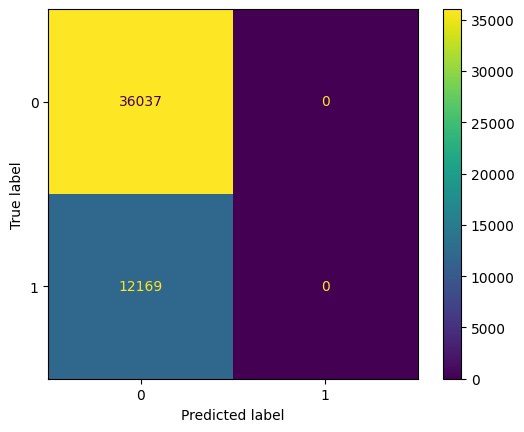

In [77]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=sgd.classes_
)
disp.plot()

### Random Forest


In [78]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.9734472887192466


[[35735   302]
 [  978 11191]]


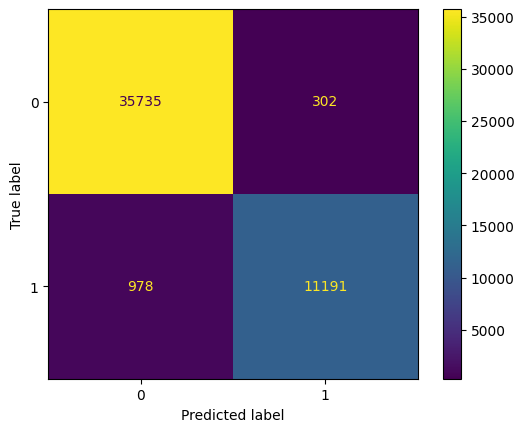

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=clf.classes_
)
disp.plot()